In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os



from IPython.display import display, HTML

In [133]:
def list_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

In [134]:
def most_recent_directory(directory):
    dirs = list_directories(directory)
    if not dirs:
        return None
    
    most_recent = max(dirs, key=lambda d: os.path.getctime(os.path.join(directory, d)))
    return os.path.join(directory, most_recent)

In [135]:
def mean_of_chunks(series, chunk_size):
    # Explicitly setting numeric_only to True to avoid FutureWarning about deprecation
    return series.groupby(np.arange(len(series)) // chunk_size).mean(numeric_only=True)

In [136]:
base_folder = ".."
path = f"{base_folder}/output/host/workload=bitbrains-small/seed=0/"

recent_dir = most_recent_directory(path)
simulation_files = os.listdir(recent_dir)

In [137]:
simulation_data = []

for file in simulation_files:
    simulation_data.append(
        mean_of_chunks(pd.read_parquet(os.path.join(recent_dir, file)), 1000)
    )

In [138]:
simulation_data[0].head()

,cpu_count,mem_capacity,guests_terminated,guests_running,guests_error,guests_invalid,cpu_limit,cpu_usage,cpu_demand,cpu_utilization,cpu_time_active,cpu_time_idle,cpu_time_steal,cpu_time_lost,power_total,uptime,downtime
0,12.440,99520.0,0.0,4.889,0.0,0.0,38367.28,9598.129214,9598.129214,0.381752,973.224,2758.767,29.721,0.0,77177.762211,300000.0,0.0
1,12.440,99520.0,0.0,4.889,0.0,0.0,38367.28,12066.561652,12066.561652,0.488412,1226.278,2505.722,50.879,0.0,81974.557057,300000.0,0.0
2,12.448,99584.0,0.0,4.889,0.0,0.0,38395.04,13086.369981,13086.369981,0.518187,1325.736,2408.664,78.209,0.0,83316.468652,300000.0,0.0
3,12.440,99520.0,0.0,4.889,0.0,0.0,38367.28,9127.604039,9127.604039,0.359644,924.555,2807.445,0.299,0.0,76187.646193,300000.0,0.0
4,12.464,99712.0,0.0,4.889,0.0,0.0,38446.24,3909.118420,3909.118420,0.134652,388.991,3350.209,2.259,0.0,66056.400984,300000.0,0.0


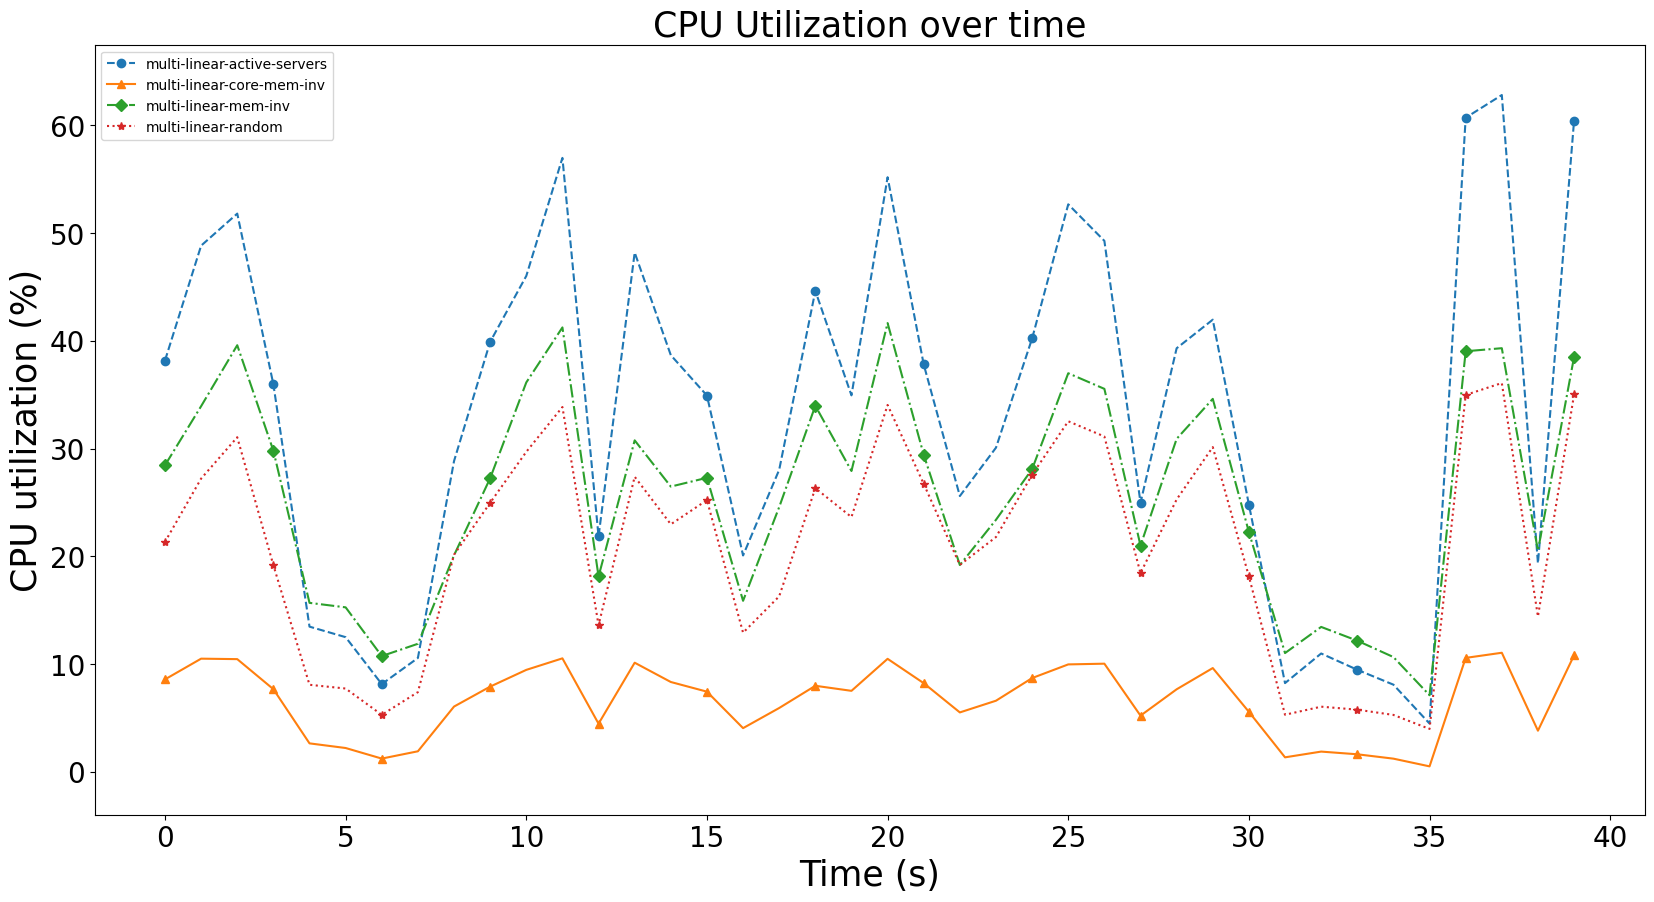

In [139]:
min_length = min([len(df) for df in simulation_data])
simulated_metrics = []

plt.figure(figsize=(20, 10))

markers = ['o', '^', 'D', '*', 'p']
marker_frequency = 3
line_styles = ['dashed', 'solid', 'dashdot', 'dotted']

for i in range(len(simulation_data)):
    df = simulation_data[i][:40]  # Ensure all plotted data have the same length
    df = df.cpu_utilization * 100
    df_label = simulation_files[i].split(".")[0]
    marker = markers[i % len(markers)]  # Use modulus to loop back to the start if there are more lines than markers
    line_style = line_styles[i % len(line_styles)]
    plt.plot(df.index, df, label=df_label, linestyle=line_style, marker=marker, markevery=marker_frequency)  # Add marker here
    
plt.legend()
plt.title("CPU Utilization over time", fontsize=25)
plt.xlabel("Time (s)", fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel("CPU utilization (%)", fontsize=25)
plt.yticks(fontsize=20)
plt.gca().set_ylim(-4, 67.5)

plt.show()

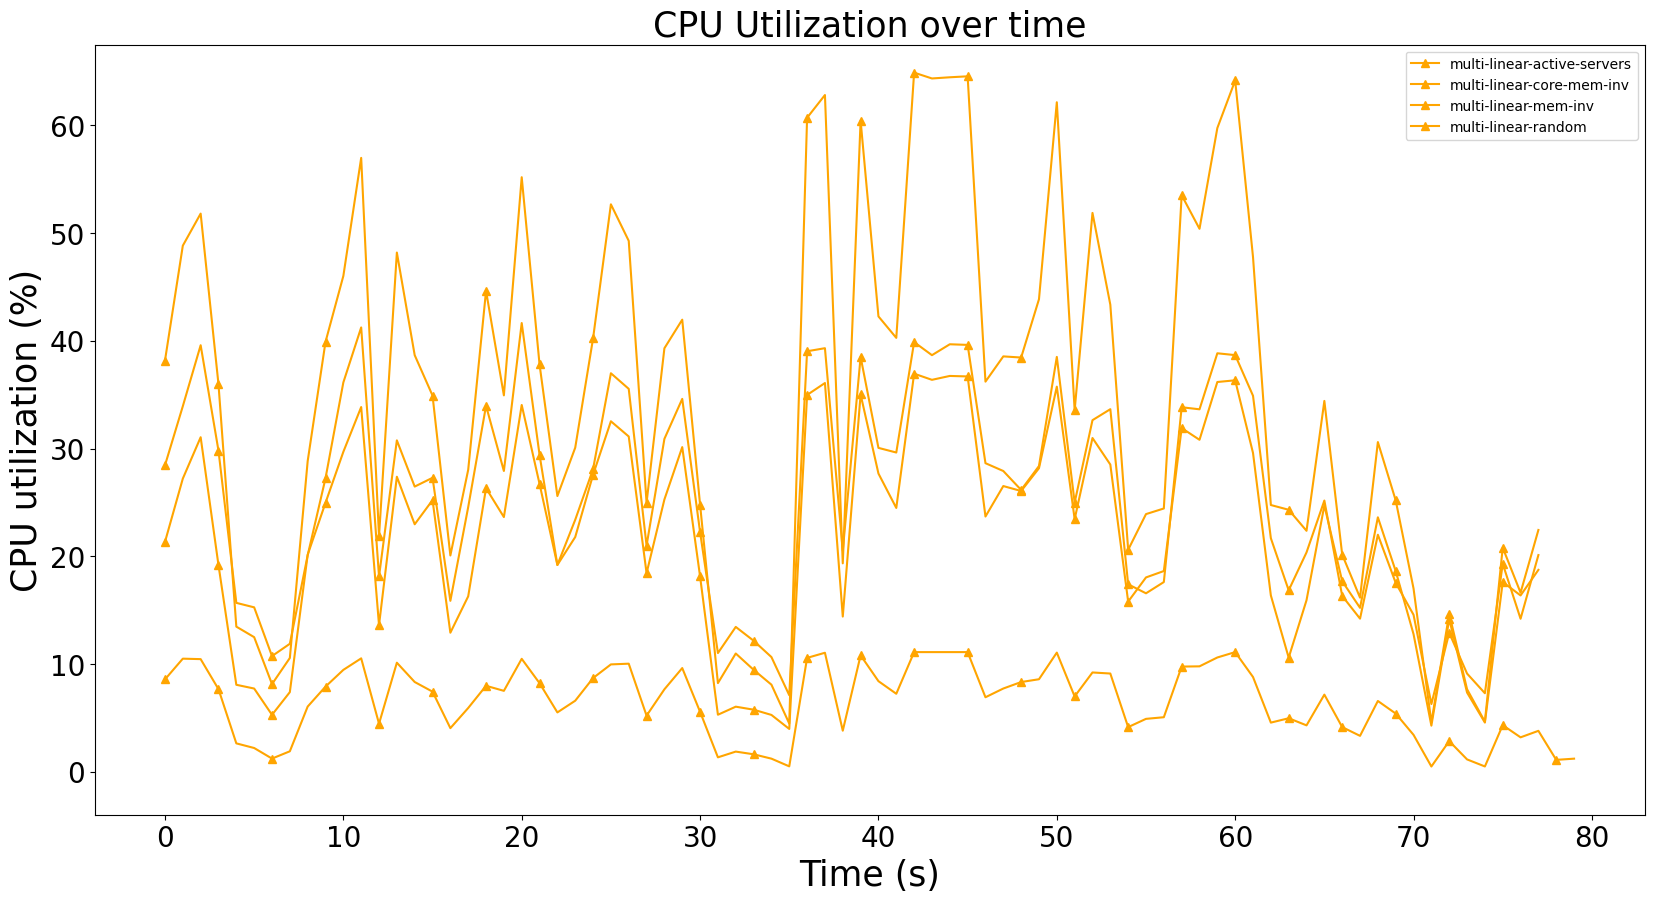

In [140]:
min_length = min([len(df) for df in simulation_data])
simulated_metrics = []

plt.figure(figsize=(20, 10))

markers = ['^']
marker_frequency = 3
# line_styles = ['dashed', 'solid', 'dashdot', 'dotted']
line_styles = ['solid']

for i in range(len(simulation_data)):
    df = simulation_data[i][:80]  # Ensure all plotted data have the same length
    df = df.cpu_utilization * 100
    df_label = simulation_files[i].split(".")[0]
    marker = markers[i % len(markers)]  # Use modulus to loop back to the start if there are more lines than markers
    line_style = line_styles[i % len(line_styles)]
    plt.plot(df.index, df, label=df_label,color="orange", linestyle=line_style, marker=marker, markevery=marker_frequency)  # Add marker here
    
plt.legend()
plt.title("CPU Utilization over time", fontsize=25)
plt.xlabel("Time (s)", fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel("CPU utilization (%)", fontsize=25)
plt.yticks(fontsize=20)
plt.gca().set_ylim(-4, 67.5)

plt.show()

# Metamodel plotting

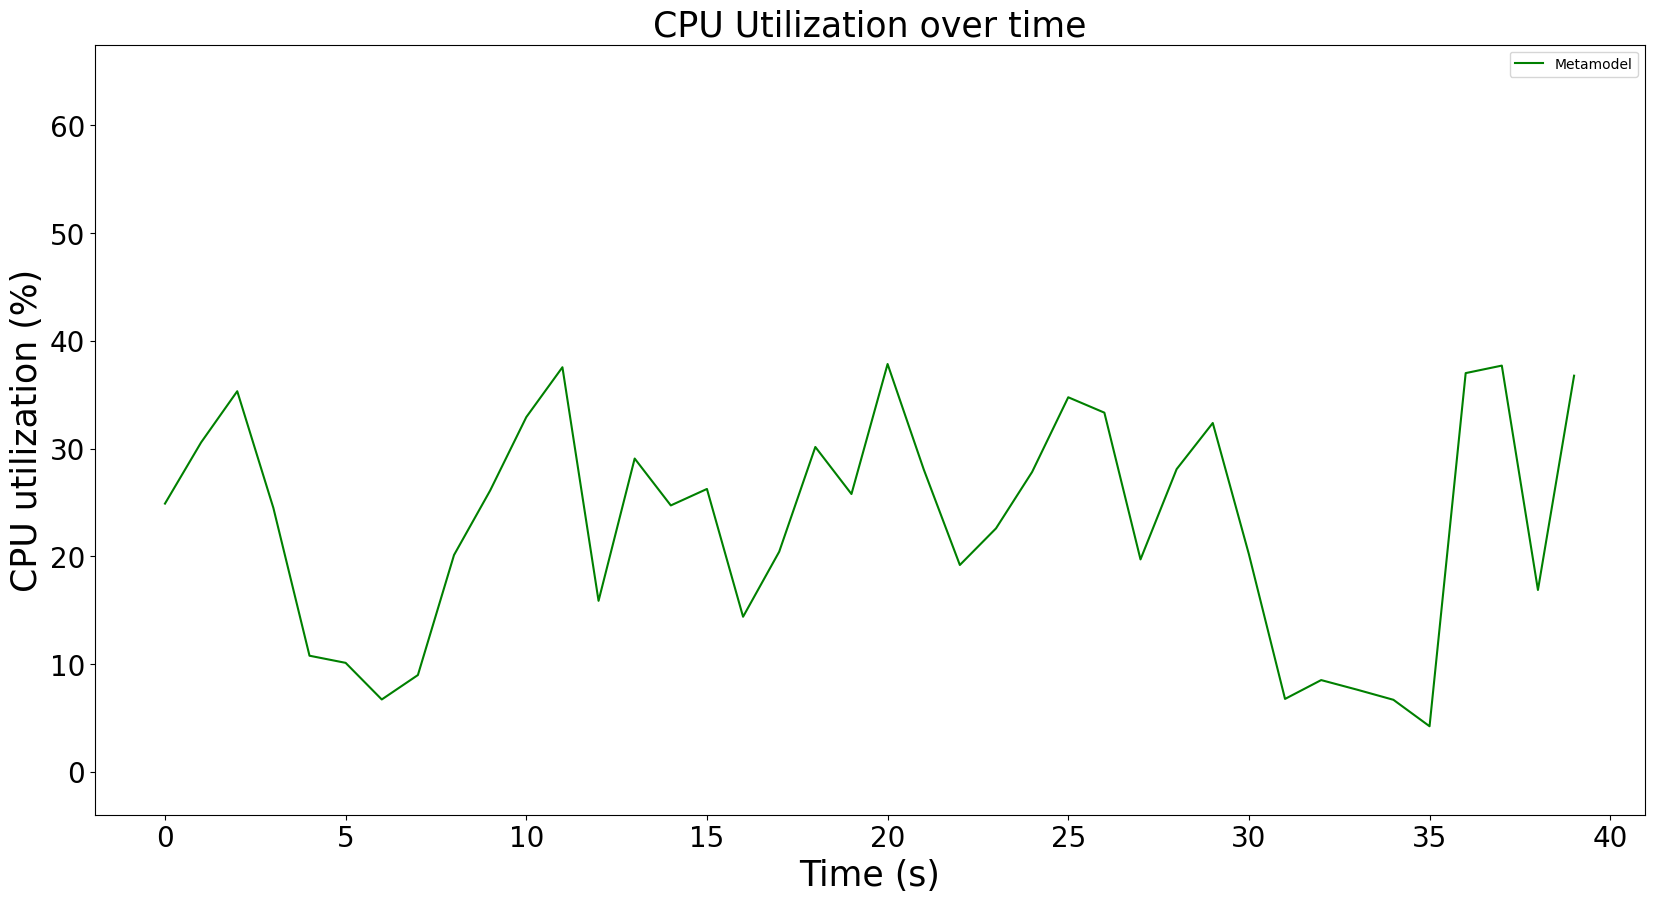

In [144]:
cpu_utilizations = []

for df in simulation_data:
    cpu_utilizations.append(df.cpu_utilization * 100)
    
combined_data = pd.concat(cpu_utilizations, axis=1)
metamodel = combined_data.median(axis=1)

plt.figure(figsize=(20, 10))
plt.plot(metamodel[:40], label="Metamodel", color="green")
plt.title("CPU Utilization over time", fontsize=25)
plt.xlabel("Time (s)", fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel("CPU utilization (%)", fontsize=25)
plt.yticks(fontsize=20)
plt.gca().set_ylim(-4, 67.5)
plt.legend()
plt.show()


# Margin of error models

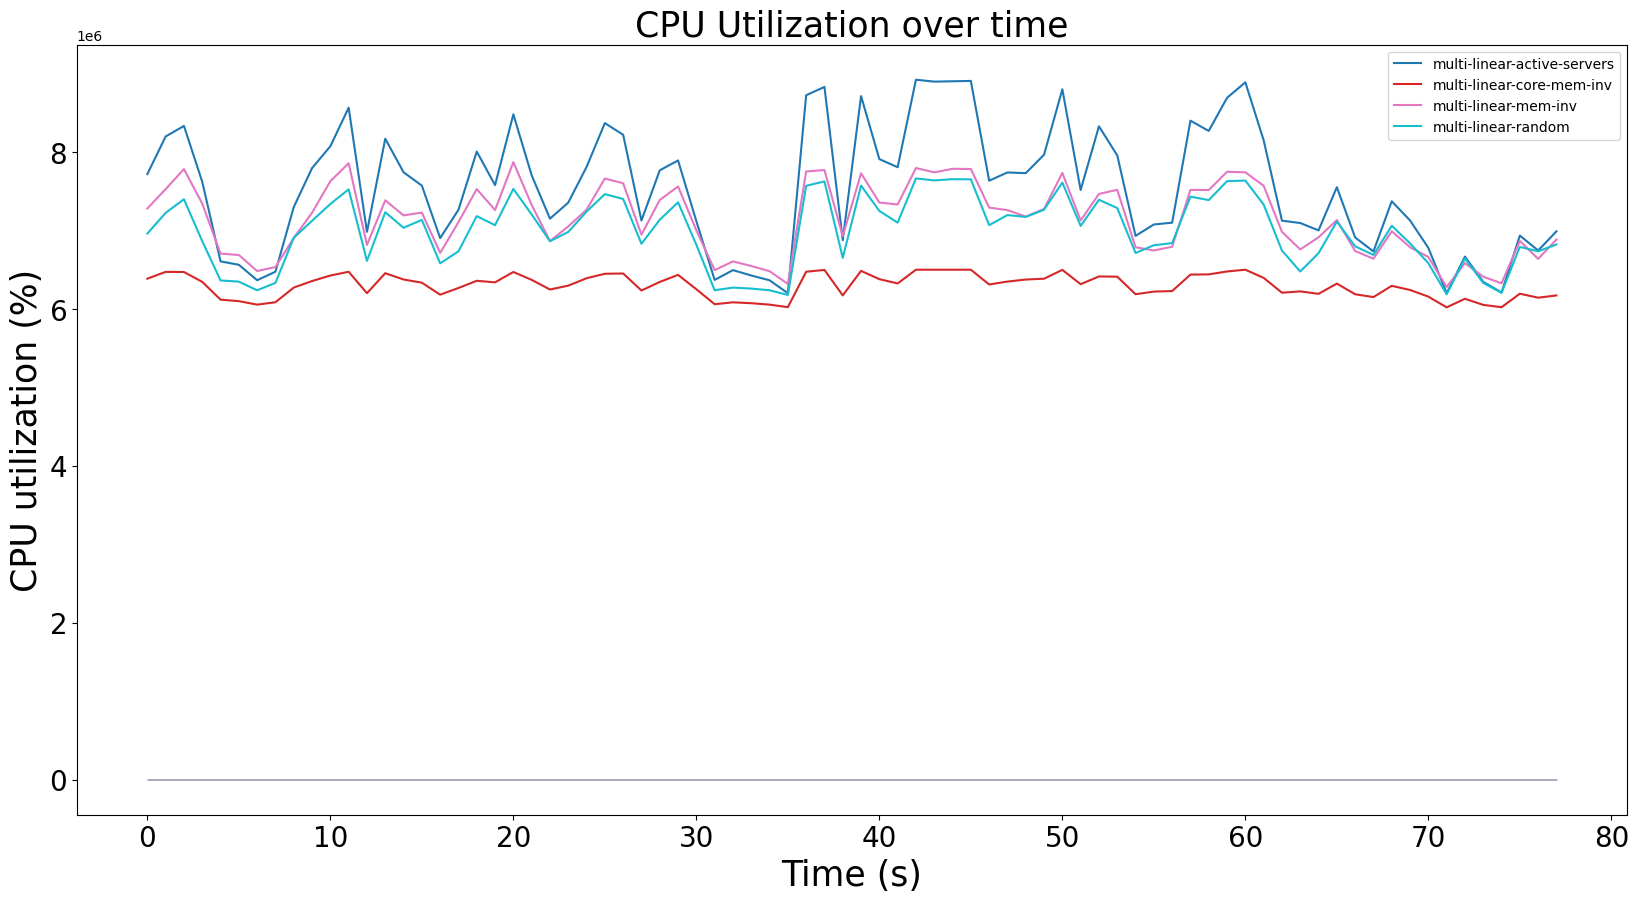

In [142]:
min_length = min([len(df) for df in simulation_data])
simulated_metrics = []

plt.figure(figsize=(20, 10))
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(simulation_data)))

# Plot the backgrounds first in reverse order
for i, color in reversed(list(enumerate(colors))):
    df = simulation_data[i][:min_length]
    y = df.cpu_utilization * 100
    x = df.index
    yerr = y * 0.2  # replace 'Error' with the actual margin of error column name
    
    # Plot background with the same color as the line
    # plt.fill_between(x, 0, y, color=color, alpha=0.1)
    # Plot the error margin
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

# Now plot the lines in correct order
for i, color in enumerate(colors):
    df = simulation_data[i][:min_length]
    y = df.power_total * 100
    x = df.index
    df_label = simulation_files[i].split(".")[0]
    
    # Plot the line with the specified color
    plt.plot(x, y, label=df_label, color=color)

# Remove the background fills from the legend
plt.legend()

plt.title("CPU Utilization over time", fontsize=25)
plt.xlabel("Time (s)", fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel("CPU utilization (%)", fontsize=25)
plt.yticks(fontsize=20)
plt.show()


# Simulation Issues

In [143]:
# Remark: although we run these 3 at the same time:
# single-powerful,linear,0.0,active-servers,2,cpu_utilization,cpu_usage,
# single-powerful,sqrt,0.0,active-servers,2,cpu_utilization,cpu_usage,
# single-powerful,square,0.0,active-servers,2,cpu_utilization,cpu_usage

# the output is 100% the same, with no difference in the CPU utilization... the issue is not from my implementation, but from the simulation itself